<a href="https://www.kaggle.com/code/hatemamine/scotus-inference-and-evaluation?scriptVersionId=107443052" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
!pip install torchmetrics --quiet
import torch
from torchmetrics import F1Score
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF 
#from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import random
random.seed(7)
import umap
import seaborn as sns
import pandas as pd
%matplotlib inline

#load the embedding for trainset to make support set 
with open('../input/scotus-embedding/embeddingsSCOTUStrain.pickle', 'rb') as handle:
    embeddings_train = pickle.load(handle)
print(embeddings_train.keys())
#load the embedding for validationset to make query set
with open('../input/scotus-embedding/embeddingsSCOTUSvalidation.pickle', 'rb') as handle:
    embeddings_validation = pickle.load(handle)
print(embeddings_validation.keys())
# get the number of class
numberofclass = len(pd.unique(embeddings_train["lable"]))
print(numberofclass)

dict_keys(['embeddings_train', 'lable'])
dict_keys(['embeddings_validation', 'lable'])
13


In [7]:
def getF1score(y_true, y_pred):
    f1 = F1Score(average='micro')
    Ttrue_scores = torch.tensor(y_true)
    Ttrue_scores = Ttrue_scores.long()
    Tpredected_scores = torch.tensor(y_pred)
    fmicro =f1(Tpredected_scores, Ttrue_scores)
    f1 = F1Score(average='macro', num_classes= numberofclass)
    fmacro =f1(Tpredected_scores, Ttrue_scores)
    f1 = F1Score()
    f1s =f1(Tpredected_scores, Ttrue_scores)
    #fmicro=f1_score(y_true, y_pred, average='micro', zero_division=1)
    #fmacro=f1_score(y_true, y_pred, average='macro', zero_division=1)
    print("score micro is ", fmicro)
    print("score macro is ", fmacro)
    print("score macro is ", f1s)
    return fmicro, fmacro, f1s

In [6]:
def getsupportset(k):
    random.seed(7)
    support_set=[]
    support_set_lable=[]
    print(k)
    for i in tqdm(range(numberofclass*k)):
        key =-1
        while key != i % numberofclass:
            ind = random.randint(0, len(embeddings_train["embeddings_train"])-1)
            key = embeddings_train["lable"][ind]
            if key == i % numberofclass:
                support_set_lable.append(key)
                #Compute cosine-similarities
                support_set.append(embeddings_train["embeddings_train"][ind])
    return support_set, support_set_lable
#support_set, support_set_lable = getsuportset_train(2)
#print(support_set_lable)


In [8]:
def getoptimalk(support_set, support_set_lable, krange, unseen):
    Xf1_micro=[]
    Xf1_macro=[]
    for i in krange:
        y_true=[]
        y_pred=[]
        neigh = KNeighborsClassifier(n_neighbors=i,  weights="distance", metric="minkowski", p=1)
        #fit KNN in the suport set 
        neigh.fit(support_set, support_set_lable)
        # evaluate KNN in the trainin set (exclude lable 0 and lable 1) + support set 
        for j in range(len(embeddings_train["embeddings_train"])):
            if embeddings_train["lable"][j] not in unseen:
                y_true.append(embeddings_train["lable"][j])
                y_pred.append(neigh.predict([embeddings_train["embeddings_train"][j]])[0])
        fscor_micro=f1_score(y_true, y_pred, average='micro', zero_division=1)
        fscor_macro=f1_score(y_true, y_pred, average='macro', zero_division=1) 
        Xf1_micro.append(fscor_micro)
        Xf1_macro.append(fscor_macro)
    print(len(Xf1_micro))
    return max(Xf1_micro), Xf1_micro.index(max(Xf1_micro)), max(Xf1_macro), Xf1_macro.index(max(Xf1_macro))


In [ ]:
#x=[1, 2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
x=np.arange(1,102)
f1s_KNN_micro=[]
koptim_KNN_micro=[]
f1s_KNN_macro=[]
koptim_KNN_macro=[]
for i in x:
    e, l =getsupportset(i)
    k=x[:min(i*13, 100)]
    f1_micro, k_index_micro, f1_macro, k_index_macro= getoptimalk(e, l, k, [0, 1])
    f1s_KNN_micro.append(f1_micro)
    koptim_KNN_micro.append(x[k_index_micro])
    f1s_KNN_macro.append(f1_macro)
    koptim_KNN_macro.append(x[k_index_macro])

1


  0%|          | 0/13 [00:00<?, ?it/s]

13
2


  0%|          | 0/26 [00:00<?, ?it/s]

26
3


  0%|          | 0/39 [00:00<?, ?it/s]

39
4


  0%|          | 0/52 [00:00<?, ?it/s]

52
5


  0%|          | 0/65 [00:00<?, ?it/s]

65
6


  0%|          | 0/78 [00:00<?, ?it/s]

78
7


  0%|          | 0/91 [00:00<?, ?it/s]

91
8


  0%|          | 0/104 [00:00<?, ?it/s]

100
9


  0%|          | 0/117 [00:00<?, ?it/s]

100
10


  0%|          | 0/130 [00:00<?, ?it/s]

100
11


  0%|          | 0/143 [00:00<?, ?it/s]

100
12


  0%|          | 0/156 [00:00<?, ?it/s]

100
13


  0%|          | 0/169 [00:00<?, ?it/s]

100
14


  0%|          | 0/182 [00:00<?, ?it/s]

100
15


  0%|          | 0/195 [00:00<?, ?it/s]

100
16


  0%|          | 0/208 [00:00<?, ?it/s]

100
17


  0%|          | 0/221 [00:00<?, ?it/s]

100
18


  0%|          | 0/234 [00:00<?, ?it/s]

100
19


  0%|          | 0/247 [00:00<?, ?it/s]

100
20


  0%|          | 0/260 [00:00<?, ?it/s]

100
21


  0%|          | 0/273 [00:00<?, ?it/s]

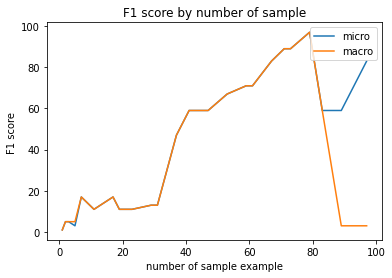

best k for FSL/micro 37
best k for KNN/micro 47
best k for FSL/macro 37
best k for KNN/micro 47


In [11]:
koptim_KNN_micro0 = [x/1 for x in koptim_KNN_micro]
koptim_KNN_macro0 = [x/1 for x in koptim_KNN_macro]
#plt.plot(x, f1s_KNN_micro)
#plt.plot(x, f1s_KNN_macro)
plt.plot(x, koptim_KNN_micro0)
plt.plot(x, koptim_KNN_macro0)
plt.title('F1 score by number of sample')
plt.ylabel('F1 score ')
plt.xlabel('number of sample example')
plt.legend(['micro', 'macro'], loc='upper right')
plt.show()
print("best k for FSL/micro", x[f1s_KNN_micro.index(max(f1s_KNN_micro))])
print("best k for KNN/micro", koptim_KNN_micro[f1s_KNN_micro.index(max(f1s_KNN_micro))]) 
print("best k for FSL/macro", x[f1s_KNN_macro.index(max(f1s_KNN_macro))])
print("best k for KNN/micro", koptim_KNN_macro[f1s_KNN_macro.index(max(f1s_KNN_macro))]) 

In [14]:
def gety_true_y_pred(e, l, k, nl=None, unseen=[], ev=embeddings_validation["embeddings_validation"], lv=embeddings_validation["lable"]):
        y_true=[]
        y_pred=[]
        neigh = KNeighborsClassifier(n_neighbors=k, weights="distance", metric="minkowski", p=1)
        neigh.fit(e, l)
        if nl==None:
            for j in range (len(ev)):
                if lv[j] not in unseen:
                    y_true.append(lv[j])
                    pred=neigh.predict([ev[j]])
                    y_pred.append(pred[0])
        else:
            for j in range (len(ev)):
                if lv[j]==nl:
                    y_true.append(lv[j])
                    pred=(neigh.predict([ev[j]]))
                    y_pred.append(pred[0])
        return y_true, y_pred

In [ ]:
e, l =getsupportset(8)
#e, l= getUMAPembedding(e, l)
#e0, l0= getUMAPembedding(embeddings_validation["embeddings_validation"], embeddings_validation["lable"])
y_true_KNN, y_pred_KNN = gety_true_y_pred(e, l, bestKNN_k,None,[])
getF1score(y_true_KNN, y_pred_KNN)

In [16]:
#best k for FSL/micro 41
#best k for KNN/micro 89
#best k for FSL/macro 89
#best k for KNN/micro 31
#fslk37 kknn16 0.7164 0.6057
#bestFSL_k =x[f1s_KNN_micro.index(max(f1s_KNN_micro))]
#bestKNN_k =x[koptim_KNN_micro[f1s_KNN_micro.index(max(f1s_KNN_micro))]-1]
bestFSL_k =x[f1s_KNN_macro.index(max(f1s_KNN_macro))]
bestKNN_k = 16
#koptim_KNN_macro[f1s_KNN_macro.index(max(f1s_KNN_macro))]
print(bestFSL_k, bestKNN_k)
e, l = getsupportset(bestFSL_k)
y_true_KNN, y_pred_KNN = gety_true_y_pred(e, l, bestKNN_k)
getF1score(y_true_KNN, y_pred_KNN)

37 16
37


  0%|          | 0/481 [00:00<?, ?it/s]

score micro is  tensor(0.7164)
score macro is  tensor(0.6057)
score macro is  tensor(0.7164)


(tensor(0.7164), tensor(0.6057), tensor(0.7164))

In [ ]:
def getSVMf1(X, y, unseenlable):
    #SVC(gamma=2, C=1)
    y_pred=[]
    y_true=[]
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X, y)
    for j in range(len(embeddings_train["lable"])):
        if embeddings_train["lable"][j] not in unseenlable:
            y_true.append(embeddings_train["lable"][j])
            pred=(clf.predict([embeddings_train["embeddings_train"][j]]))
            y_pred.append(pred[0])
    fscor_micro=f1_score(y_true, y_pred, average='micro', zero_division=1) 
    fscor_macro=f1_score(y_true, y_pred, average='macro', zero_division=1)
    return fscor_micro, fscor_macro

In [ ]:
x=[1, 2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
f1s_SVM_micro=[]
f1s_SVM_macro=[]
for i in x:
    e, l =getsupportset(i)
    f1micro, f1macro= getSVMf1(e, l, [0, 1])
    f1s_SVM_micro.append(f1micro)
    f1s_SVM_macro.append(f1macro)
plt.plot(x, f1s_SVM_micro)
plt.plot(x, f1s_SVM_macro)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['micro', 'macro'], loc='upper right')
plt.show()
print("index best f1 micro", f1s_SVM_micro.index(max(f1s_SVM_micro)))
print("best f1 micro", max(f1s_SVM_micro))
print("bset k for FSL micro", x[f1s_SVM_micro.index(max(f1s_SVM_micro))])

print("index best f1 macro",f1s_SVM_macro.index(max(f1s_SVM_macro)))
print("best f1 macro", max(f1s_SVM_macro))
print("bset k for FSL macro ", x[f1s_SVM_macro.index(max(f1s_SVM_macro))])


In [ ]:
def getSVMy_truey_pred(e, l, nl=None, unseen=[]):
        y_true=[]
        y_pred=[]
        #SVC(gamma=2, C=1)
        neigh = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        neigh.fit(e, l)
        if nl==None:
            for j in range (len(embeddings_validation["embeddings_validation"])):
                if embeddings_validation["lable"][j] not in unseen:
                    y_true.append(embeddings_validation["lable"][j])
                    pred=neigh.predict([embeddings_validation["embeddings_validation"][j]])
                    y_pred.append(pred[0])
        else:
            for j in range (len(embeddings_validation["embeddings_validation"])):
                if embeddings_validation["lable"][j]==nl:
                    y_true.append(embeddings_validation["lable"][j])
                    pred=(neigh.predict([embeddings_validation["embeddings_validation"][j]]))
                    y_pred.append(pred[0])
        return y_true, y_pred

best_k_svm = x[f1s_SVM_micro.index(max(f1s_SVM_micro))]
#best_k_svm = x[f1s_SVM_macro.index(max(f1s_SVM_macro))]
e, l =getsupportset(best_k_svm)
y_true_svm, y_pred_svm =getSVMy_truey_pred(e, l,None)
getF1score(y_true_svm, y_pred_svm)

#for i in range(len(y_pred_svm)):
#   if y_pred_svm[i]!=y_true_svm[i] or y_pred_KNN[i]!=y_true_KNN[i]:print('fals', y_pred_svm[i], y_true_svm[i], y_pred_KNN[i], y_true_KNN[i] )

In [ ]:
def plotConfusion_Matrix(y_true, y_pred, numberofclass, outputfile_name):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(numberofclass)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(range(numberofclass)))
    disp.plot()
    plt.savefig(outputfile_name+".png")
    plt.show()

In [ ]:
def getUMAPembedding(e, l):
    reducer = umap.UMAP(random_state=42)
    reducer.fit(e)
    embedding = reducer.transform(e)
    # Verify that the result of calling transform is
    # idenitical to accessing the embedding_ attribute
    assert(np.all(embedding == reducer.embedding_))
    embedding.shape
    plt.scatter(embedding[:, 0], embedding[:, 1], c=l, cmap='Spectral', s=10)
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(13)-1)
    #plt.title('UMAP projection of the embedding words', fontsize=24);
    plt.savefig("UMAP_Embedding_SCOTUS.png")
    e0=[]
    for i in range(embedding.shape[0]):
        e0.append(embedding[i])  
    return e0, l

In [ ]:
r0=[0.8958,0.5000, 0.0545, 0.7590, 0.6721]
r=[0.9083, 0.7248, 0.7207, 0.5810]
bars = ('unseen label 0', 'unseen label 1', 'F1 micro', 'F1 macro')
def plot_resulta(resulta, bars):
    #plt.plot(X,  unseen1Xmicrof1  , marker='D', linewidth=6)
    #bars = ('unseen 0', 'unseen 1','unseen  2', 'F1 micro', 'F1 macro')
    x_pos = np.arange(len(bars))
    # Create bars with different colors
    plt.bar(x_pos, r, color=[(0.1, 0.1, 0.1, 0.1),(1, 1, 1, 0.1), (1, 0.7, 0.7, 0.7), (0.7, 0.7, 0.7, 0.7)],  edgecolor='blue')
    # Create names on the x-axis
    plt.xticks(x_pos, bars)
    plt.savefig("f1_SCOTUS.png")
    # Show graph
    plt.show()
plot_resulta(r, bars)